simple_XRD.jl
by Hezy Amiel
January 2023
Julia 1.8.5

In [122]:
using Plots
using SpecialFunctions

In [123]:
function Gaussian(x, fwhm)
    σ = fwhm/(2√(2log(2)))
    return @. 1/√(2π)/σ * exp(-x^2/2σ^2)
end

Gaussian (generic function with 1 method)

In [124]:
function Lorentzian(x, fwhm)
    γ = fwhm / 2
    return @. (γ/pi) / (x^2 + γ^2)
end

Lorentzian (generic function with 1 method)

In [125]:
function Pseudo_Voigt(x, fwhm, n)
	return n * Lorentzian(x, fwhm) + (1 - n) * Gaussian(x, fwhm)
end

Pseudo_Voigt (generic function with 1 method)

In [126]:
function Voigt(x, fwhm_L, fwhm_G)
    γ = fwhm_L/2
    σ = fwhm_G/(2√(2log(2)))
    z = @. -im * (x + im * γ) / (√2 * σ)
    return @. real(erfcx(z)) / (√(2pi) * σ)
end

Voigt (generic function with 1 method)

In [127]:
function peak(θ, θ_0, A, w, n)
    return @. A * Pseudo_Voigt(θ-θ_0, w, n)
end

peak (generic function with 1 method)

In [128]:
function peaks_width(two_θ_deg, U, V, W)
    two_θ_rad = two_θ_deg * π/180
    return @. √(U * tan(two_θ_rad/2)^2 + V * tan(two_θ_rad/2) + W)
end

peaks_width (generic function with 1 method)

In [129]:
function bragg_angels(wavelength, d_spacings)
    sinθ = wavelength ./ (2*d_spacings)
    sinθ_cleaned = [item for item in sinθ if abs(item)<=1]  # removing values outside (-1,1)
    return 2 * (180/π) * asin.(sinθ_cleaned)  # *2 for 2θ  
end

bragg_angels (generic function with 1 method)

In [130]:
function d_list(indices, a)
    return a ./ .√(sum(indices.^2, dims=2))
end

d_list (generic function with 1 method)

General Sttings

In [131]:
N = 1000
θ = collect(LinRange(0, 180, N))
y = zeros(N)
#θ = range(start=0, stop=180, step=180/N)
wavelength = 0.15418  # CuKα radiation in nm
#wavelength = 0.18125  # 
U, V, W = 0.2, 0.2, 0.2

(0.2, 0.2, 0.2)

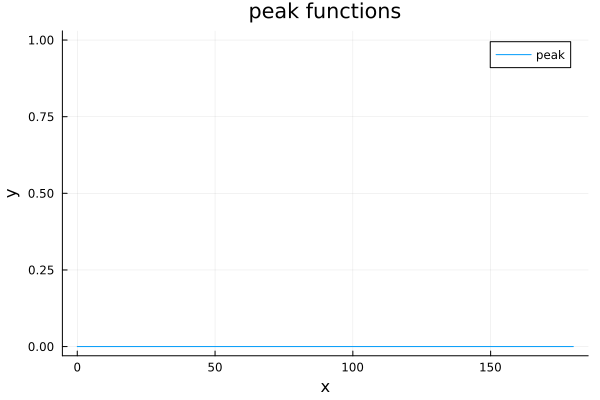

#Simple Cubic

In simple cubic lattince, all Miller indices are allowed

In [133]:
a_SC = 0.3352

0.3352

In [134]:
generate_indices = [[h,k,l] for h=0:3 for k=0:3 for l=0:3 if [h,k,l]!=[0,0,0]]
indices_SC = (reduce(hcat, generate_indices))'

63×3 adjoint(::Matrix{Int64}) with eltype Int64:
 0  0  1
 0  0  2
 0  0  3
 0  1  0
 0  1  1
 0  1  2
 0  1  3
 0  2  0
 0  2  1
 0  2  2
 ⋮     
 3  1  3
 3  2  0
 3  2  1
 3  2  2
 3  2  3
 3  3  0
 3  3  1
 3  3  2
 3  3  3

In [135]:
two_θ_list = bragg_angels(wavelength, d_list(indices_SC, a_SC))

56-element Vector{Float64}:
  26.592035832220116
  54.76959489844517
  87.25171650959486
  26.592035832220116
  37.96069301336359
  61.89542375307041
  93.31557037970785
  54.76959489844517
  61.89542375307041
  81.15675142339374
   ⋮
 112.03580473576237
 154.70282122015084
  93.31557037970785
  99.41701071913283
 118.74873813556404
 112.03580473576237
 118.74873813556404
 142.96997789440667
 154.70282122015084

In [137]:
y = zeros(N)
for item in two_θ_list
    y = y + peak(θ, item, 1, 2, 0.5)
end


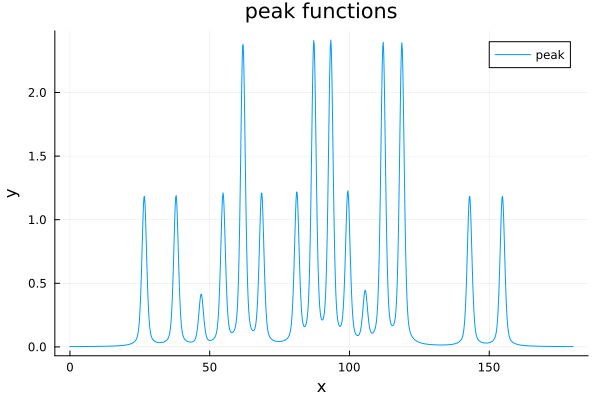

In [138]:
p = plot(θ, y, label="peak")
title!("peak functions")
xlabel!(raw"x")
ylabel!(raw"y")